In ths code, we are going to try the RandomForest Classification model by open source library Scikit-learn (sklearn)

In [35]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from statistics import mean

import seaborn as sns
import math

import matplotlib.pyplot as plt
%matplotlib inline


In [36]:
document_risk = pd.read_csv("./qa06_only_having_risk_valuesl.csv")
document_risk = document_risk.rename(columns={'qa06id': 'id', 'qa06name':'title', 'qa06wher':'location','qa06dsc':'report','ty26colo':'label','ty26fakt':'factor'})

In [37]:
doc_risk_tok=pd.read_csv('./doc_risk_tok.csv',index_col=0)

pdoc_risk=pd.read_csv('./pdoc_risk.csv',index_col=0)
tokens_risk=pd.read_csv('./tokens_risk.csv',index_col=0)

sparse_risk=pd.read_csv('./sparse_risk.csv',index_col=0)

The performance of the model will be measured with 3 different standard measures: Precision, Recall and F1-score that are all readable from confusion matrix. Confusion matrix is a type of presentation of model performance. There is a number of correct predictions for every combination of real and predicted class belonging. Once again you can use some one-line function from open source library, but I did it myself because of better understanding what it really is. <br> 
This is how our model will be tested: we are going to split our data into two parts: training part (which will help to train our model) and testing part (which will be used to test the model and measure its performance). After we predict classes for our test data we are going to write the results in a confusion matrix. For spliting data part, we used sklearn library again. <br> <br> Important thing to mention is that we are going to do the whole experiment 10 times. All of it: spliting the data, fitting the model, predicting the classes for testing set, making a confusion matrix and finally measure the precision, recall and F1-measure. Final result will be mean of all 10 experiments.

In [39]:
RFC_results=pd.DataFrame(columns=['Precision','Recall','F1-score'],index=range(10))

for i in range(10):       #10 experiments

    zero = np.zeros(shape=(3,3))
    conf_matrix=pd.DataFrame(zero,columns=['no accident outcome','minor injuries or damage',
                                              'major or catastrophic accident'],
                                index=['no accident outcome','minor injuries or damage',
                                              'major or catastrophic accident'])


    #spliting the data
    X_train, X_val, y_train, y_val = train_test_split(doc_risk_tok.index.values, 
                                                  doc_risk_tok.accident.values, 
                                                  test_size=0.2, 
                                                  random_state=42, 
                                                  stratify=doc_risk_tok.accident.values)
    doc_risk_tok['data_type'] = ['not_set']*doc_risk_tok.shape[0]
    doc_risk_tok.loc[X_train, 'data_type'] = 'train'
    doc_risk_tok.loc[X_val, 'data_type'] = 'val'
    

#     xx_train is just a list of id numbers of reports that will be used for training the model
#     the same is with xx_val
    xx_train=doc_risk_tok[doc_risk_tok.data_type=='train'].xx   
    xx_val=doc_risk_tok[doc_risk_tok.data_type=='val'].xx
    
#     there are many features that can be used in this model. In our data set,
#     most importan feature is class_weight='balanced' because our set is not balanced
#     (there is much more "no accident outcome" than "major or catastrophic accident" reports)
   
    clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', max_features=None) #defining the model
    clf.fit(sparse_risk.loc[doc_risk_tok[doc_risk_tok.data_type=='train'].xx],doc_risk_tok[doc_risk_tok.data_type=='train'].accident)  #fitting the model

#     After we fit the data it is time to predict the classes for our test data, one by one and 
#     writing it down in our confusion matrix
    
    for w in xx_val:
        risk_level = clf.predict(np.array(sparse_risk.loc[w]).reshape(1,-1))[0]   #predicting the class for each report in test set
        conf_matrix.loc[risk_level][doc_risk_tok[doc_risk_tok.xx==w].accident]+=1
    

    p0=conf_matrix.loc['no accident outcome']['no accident outcome']/(sum(conf_matrix.loc['no accident outcome']))
    p1=conf_matrix.loc['minor injuries or damage']['minor injuries or damage']/(sum(conf_matrix.loc['minor injuries or damage']))
    p2=conf_matrix.loc['major or catastrophic accident']['major or catastrophic accident']/(sum(conf_matrix.loc['major or catastrophic accident']))
    r0=conf_matrix.loc['no accident outcome']['no accident outcome']/(sum(conf_matrix['no accident outcome']))
    r1=conf_matrix.loc['minor injuries or damage']['minor injuries or damage']/(sum(conf_matrix['minor injuries or damage']))
    r2=conf_matrix.loc['major or catastrophic accident']['major or catastrophic accident']/(sum(conf_matrix['major or catastrophic accident']))
    P=mean([p0,p1,p2])
    R=mean([r0,r1,r2])
    F1=(2*P*R)/(P+R)  # formula for F1-measure

    RFC_results.loc[i]['Precision']=P
    RFC_results.loc[i]['Recall']=R
    RFC_results.loc[i]['F1-score']=F1

    print(conf_matrix)
    
print(RFC_results) #all 10 precisions, recalls and F1 measures
RESULTS=pd.DataFrame(columns=['PRECISION','RECALL','F1-SCORE'],index=['Value'])    
RESULTS['PRECISION']=sum(RFC_results['Precision'])/10
RESULTS['RECALL']=sum(RFC_results['Recall'])/10
RESULTS['F1-SCORE']=sum(RFC_results['F1-score'])/10

                                no accident outcome  ...  major or catastrophic accident
no accident outcome                            83.0  ...                            19.0
minor injuries or damage                       98.0  ...                            42.0
major or catastrophic accident                  3.0  ...                             6.0

[3 rows x 3 columns]
                                no accident outcome  ...  major or catastrophic accident
no accident outcome                            85.0  ...                            21.0
minor injuries or damage                       95.0  ...                            39.0
major or catastrophic accident                  4.0  ...                             7.0

[3 rows x 3 columns]
                                no accident outcome  ...  major or catastrophic accident
no accident outcome                            92.0  ...                            21.0
minor injuries or damage                       89.0  ...          

In [40]:
print (RESULTS)   #if you want to see final results (mean of all 10 results)

       PRECISION    RECALL  F1-SCORE
Value   0.471989  0.432959  0.451571


Down is little code addition showing 10 most important tokens (terms) with this classification model on our data set.

Text(0.5, 0, 'Random Forest Feature Importance')

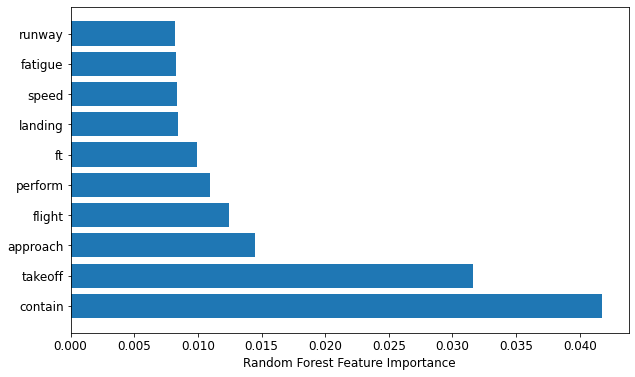

In [41]:
clf.feature_importances_
sorted_idx = clf.feature_importances_.argsort() #indeksi sortiranog vektora
#sorted_features = clf.feature_importances_.sort #sortirani vektor
ide = [0]*len(sorted_idx)
for i in range (len (sorted_idx)):
    ide[i] = clf.feature_importances_[sorted_idx[i]]
ide2=[0]*10
idx2=[0]*10
for i in range (10):
    idx2[i]=sorted_idx[len(sorted_idx)-1-i]
    ide2[i] = ide[len(sorted_idx)-i-1]
columnnames=['']*10
j=0
col_names=list(sparse_risk.columns)
for i in idx2:
    columnnames[j]=col_names[i]
    j=j+1
plt.rcParams.update({'figure.figsize': (10.0, 6.0)})
plt.rcParams.update({'font.size': 12})
#col_names=list(sparse_risk.columns)
plt.barh(columnnames, ide2)
plt.xlabel("Random Forest Feature Importance")

Our model does not show any good results. There are few possible explanations. 
First, our data set is imbalanced.

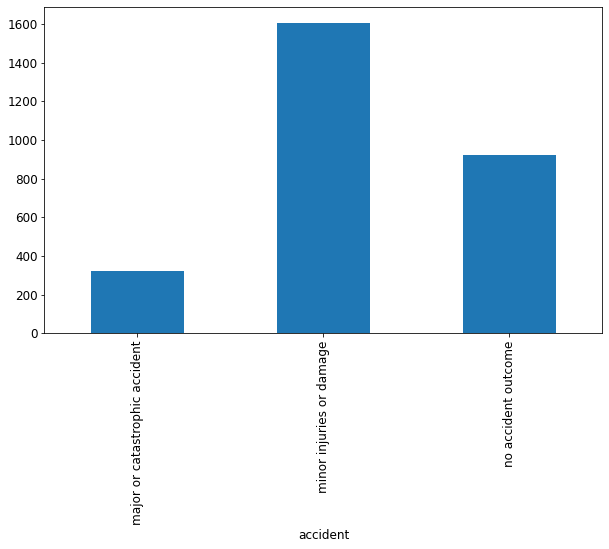

In [42]:
doc_risk_tok.groupby('accident').accident.count().plot.bar(ylim=0)
plt.show()

Next possible explanation is the small number of tokens in every report.

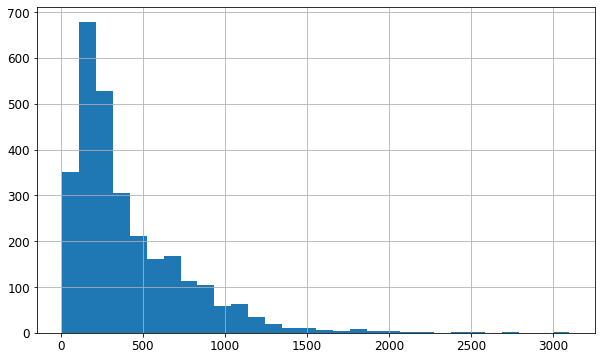

In [58]:
sequence_len=[]
for i in range(len(doc_risk_tok)):
  sequence_len.append(len(doc_risk_tok.report[i]))

pd.Series(sequence_len).hist(bins = 30)